# Sam's Jupyter Notebook
Shoutout to Munshi for helping out a lot with getting this set up properly

### Installing the required libraries

In [1]:
from pydeck import nbextension
import widgetsnbextension
!pip install matplotlib geopandas plotly pygris folium
!pip install jupyterlab_widgets ipywidgets
!pip install openmeteo-requests

In [2]:
!pip install nbformat cartopy seaborn
!pip install certifi

### Importing libraries

In [3]:
import matplotlib.pyplot as plt # to make static plots
import pandas as pd # data loading and manipulation
import geopandas as gpd # to handle the geospatial data
from shapely.geometry import Point, box # GeoPandas includes shapely, which we’ll use to create a geospatially aware GeoDataFrame from the CSV file.

### Loading Data and Preparing the GeoDataFrame
The NOAA CSV file is stored on a Gist for convenience. We’ll start by loading it as a pandas DataFrame and then filter out the non-contiguous US components.

In [4]:
# Load the CSV file into a DataFrame
df_raw = pd.read_csv('../data/1950-2023_actual_tornadoes.csv')

# Filter out Alaska, Hawaii, Puerto Rico, and Virgin Islands: The tilde (~) in the second line negates the boolean Series. So, we’re telling pandas to give us a DataFrame without the listed states.
df = df_raw[~df_raw['st'].isin(['AK', 'HI', 'PR', 'VI'])]

# Create a GeoDataFrame for the data points
geometry = gpd.array.from_shapely([Point(xy) for xy in zip(df['slon'],
                                                           df['slat'])])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Filter out rows where magnitude is -9 (unknown):
gdf = gdf[(gdf['mag'] != -9)]

The primary geospatial data in the CSV file is the latitude (slat) and longitude (slon) columns. We’ll use GeoPandas and Shapely to turn these into a geometry column, which is what distinguishes GeoDataFrames from DataFrames. We’ll also assign a coordinate reference system (crs) so GeoPandas knows how to project the data onto a flat map.

The final step filters out tornadoes with no assigned magnitude value (unknown = -9). We do this so that we can work with magnitude values later. This removes about 1,024 tornadoes from the dataset:

In [5]:
# Count the number of occurrences of -9 in the 'mag' column:
num_negative_nines = (df['mag'] == -9).sum()
print(f"Number of -9 values in the 'mag' column: {num_negative_nines}")

Number of -9 values in the 'mag' column: 1024


### Preparing the State Borders

In [6]:
import ssl
import certifi
import urllib.request

# Force use of certifi's cert bundle
ssl_context = ssl.create_default_context(cafile=certifi.where())
opener = urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_context))
urllib.request.install_opener(opener)


states_gdf = gpd.read_file("data/tl_2020_us_state/tl_2020_us_state.shp")


Next, we use the "STUSPS" column of states_gdf to filter out states and territories not in the Lower 48. Then we use the FIPS state codes in the "STSTEFP" column to filter out the counties in these excluded states from the counties_gdf GeoDataFrame.
A FIPS state code is a numeric code defined in U.S. Federal Information Processing Standard Publication ("FIPS PUB") 5–2 to identify U.S. states and other associated areas. You can find these codes [here](https://www.census.gov/library/reference/code-lists/ansi.html).

In [7]:
print("[Before filtering] Total states: ", states_gdf.shape[0])
# Filter for the contiguous US:
states_gdf = states_gdf[~states_gdf['STUSPS'].isin(['AK', 'HI', 'PR', 'VI'])]

print("[After filtering] Total states: ", states_gdf.shape[0])

[Before filtering] Total states:  56
[After filtering] Total states:  52


The last two steps create a bounding box that encompasses the contiguous US and then uses it to clip the GeoDataFrames. This produces a better-looking map, in my opinion.

In [8]:
# Create a bounding box for the specified map bounds:
bounds_box = box(-127, 23, -67, 50)  # (min_lon, min_lat, max_lon, max_lat)

# Clip the GeoDataFrames to the bounding box:
clipped_states = gpd.clip(states_gdf, bounds_box)

### Plotting the Map
Now we use Matplotlib and GeoPandas to plot the data. While GeoPandas is built on Matplotlib and can plot without it, you get more refined results using Matplotlib.

This code is annotated and straightforward. One thing to note, We are plotting the first reported location of the tornadoes (the "s" in slat and slon stands for "start").
Here’s the result, showing almost 70,000+ tornadoes:

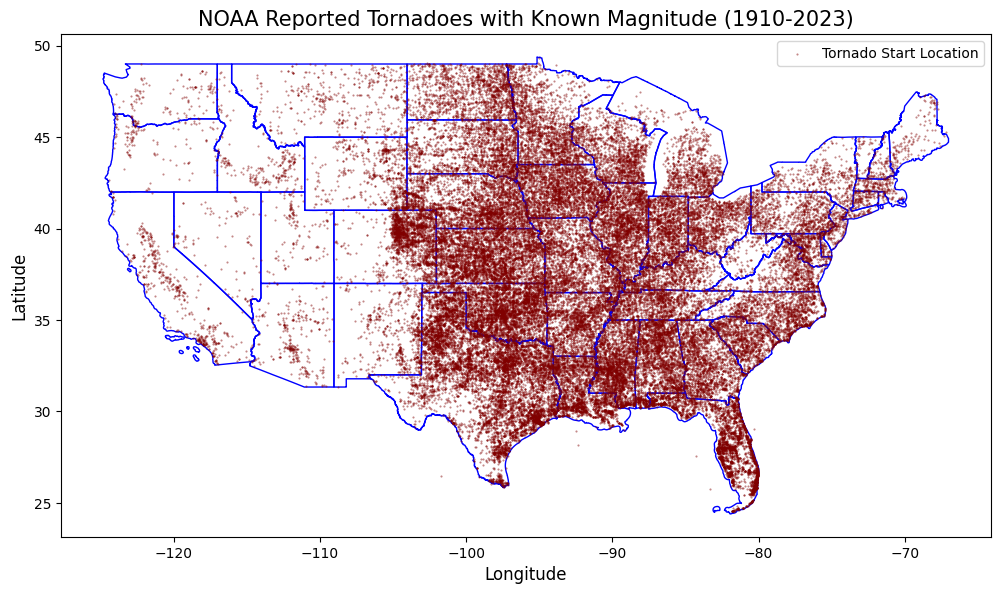

In [9]:
# Function to plot tornadoes for a given period on the US map
def plot_tornadoes_by_period(gdf, start_year, end_year):
    # Plot the filtered data:
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    # Plot the state borders:
    clipped_states.plot(ax=ax,
                        color='none',
                        edgecolor='blue',
                        linewidth=1)

    # Filter data for the specified period
    gdf_period = gdf[(gdf['yr'] >= start_year) & (gdf['yr'] <= end_year)]

    # Plot the tornado locations:
    gdf_period.plot(ax=ax,
             color='maroon',
             marker='.',
             markersize=1,
             alpha=0.5,
             label='Tornado Start Location')

    plt.title(f"NOAA Reported Tornadoes with Known Magnitude ({start_year}-{end_year})",
              fontsize=15)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend()

    plt.show()

# Plot for both periods using the function
plot_tornadoes_by_period(gdf, 1910, 2023)


In [10]:
# load weather station data
# Load the CSV file into a DataFrame
import os

stations = list()
for filename in os.listdir("../data/weather_stations/"):
    stations.append(pd.read_csv("../data/weather_stations/" + filename))

# really scuffed to get the data shaped right
pointlist = list()
for station in stations:
    newpoint = [Point(xy) for xy in zip(station["LONGITUDE"], station["LATITUDE"])]
    pointlist.append(newpoint[0])
print(pointlist)

# just pull the elevations for now
elevation = list()
for station in stations:
    elevation.append([station["STATION"][0], station["ELEVATION"][[0]]])
print(elevation)
# Create a GeoDataFrame for the data points
geometry = gpd.array.from_shapely(pointlist)


wgdf = gpd.GeoDataFrame(elevation, geometry=geometry, crs="EPSG:4326")
print(wgdf)

[<POINT (-88.19 32.581)>, <POINT (-86.3 32.383)>, <POINT (-94.174 36.101)>, <POINT (-84.583 30.583)>, <POINT (-84.504 34.207)>, <POINT (-90.183 38.567)>, <POINT (-91.505 41.609)>, <POINT (-95.147 43.165)>, <POINT (-94.919 39.326)>, <POINT (-88.782 33.469)>, <POINT (-90.911 33.431)>, <POINT (-103.021 41.229)>, <POINT (-89.032 36.392)>, <POINT (-101.822 33.69)>, <POINT (-90.078 32.32)>, <POINT (-94.026 29.952)>, <POINT (-86.745 33.565)>, <POINT (-93.824 32.447)>, <POINT (-98.493 33.979)>, <POINT (-99.769 36.297)>, <POINT (-99.969 37.771)>, <POINT (-98.223 44.379)>, <POINT (-96.687 40.839)>, <POINT (-101.717 35.22)>, <POINT (-101.693 39.367)>, <POINT (-103.601 41.875)>, <POINT (-84.606 38.041)>, <POINT (-89.684 39.845)>]
[['USC00014798', 0    39.0
Name: ELEVATION, dtype: float64], ['USC00015555', 0    78.0
Name: ELEVATION, dtype: float64], ['USC00032444', 0    387.1
Name: ELEVATION, dtype: float64], ['USC00087424', 0    75.9
Name: ELEVATION, dtype: float64], ['USC00091585', 0    345.9
Nam

In [11]:
# get the important data from the weather stations
stationdata = list()
for station in stations:
    stationdata.append([station["STATION"][0], station["ELEVATION"][1], station["DATE"], station["PRCP"], station["TAVG"], station["TMAX"], station["TMIN"]])
    # in practice this looks like ["USC0014798", 39, [1891-11, 1891-12, 1892-01...], [136.4, 140.6...], [11.57, 25.81...], [18.16, 31.85...], [4.99, 19.76...]]
    # elevation is in m, temperature is in Celsius, precipitation is in mm

twowgdf = gpd.GeoDataFrame(stationdata, geometry=geometry, crs="EPSG:4326")
print(twowgdf)

              0       1                                                  2  \
0   USC00014798    39.0  0       1891-11
1       1892-06
2       1892-0...   
1   USC00015555    78.0  0      1872-09
1      1872-10
2      1872-11
3...   
2   USC00032444   387.1  0       1892-01
1       1892-02
2       1892-0...   
3   USC00087424    75.9  0      1896-05
1      1896-06
2      1896-07
3...   
4   USC00091585   345.9  0       1891-08
1       1891-09
2       1891-1...   
5   USC00112614   125.0  0      1910-07
1      1910-08
2      1910-09
3...   
6   USC00134101   195.1  0       1893-01
1       1893-02
2       1893-0...   
7   USC00137844   404.2  0       1895-02
1       1895-03
2       1895-0...   
8   USC00144588   265.2  0       1891-12
1       1892-01
2       1892-0...   
9   USC00228374    56.4  0       1891-09
1       1891-10
2       1891-1...   
10  USC00228445    38.7  0       1914-07
1       1915-01
2       1915-0...   
11  USC00257830  1321.9  0       1908-12
1       1909-01
2      

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from ipywidgets import interact, widgets
%matplotlib widget
# Normalize the magnitude values for the colormap (globally)
norm = Normalize(vmin=1, vmax=5)
cmap = cm.viridis

wgdf = twowgdf # temp fix to see if the new df works


def plot_tornadoes_advanced(year, month, magnitude):
    print("Hover over weather stations to see more data!")
    # Plot the filtered data:
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    
    # Plot the state borders:
    clipped_states.plot(ax=ax,
                        color='none',
                        edgecolor='blue',
                        linewidth=1)

    # Filter data for the specified period
    gdf_period = gdf[(gdf['yr'] == year) & (gdf['mo'] == month)]

    # Filter for magnitude
    gdf_period = gdf_period[(gdf_period['mag'] >= magnitude[0]) & (gdf_period['mag'] <= magnitude[1])]

    # Plot the tornado locations with colors based on magnitude
    gdf_period.plot(ax=ax,
                    color=[cmap(norm(mag)) for mag in gdf_period['mag']],
                    marker='.',
                    markersize=10,
                    alpha=0.7,
                    label='Tornado Start Location')
    
    # Plot the weather station locations (scatterplot makes the hovertext actually work)
    sc = ax.scatter(wgdf.geometry.x, wgdf.geometry.y, 
                    color='green', 
                    marker='s',
                    s=40, 
                    alpha=0.5, 
                    label='Weather Station')

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Tornado Magnitude', fontsize=12)

    plt.title(f"NOAA Reported Tornadoes with Known Magnitude ({month}/{year})",
              fontsize=15)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend()

    # Add hover functionality for weather stations (AI edited code from ImportanceOfBeingErnest)
    annot = ax.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind):
        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        station_info = wgdf.iloc[ind["ind"][0]]  # get the corresponding weather station info
        # get weather info for this month
        date = f"{year}-{month:02d}"
        # find what row number this date is in the station data
        date_index = station_info[2][station_info[2].str.contains(date)].index[0]
        prcp = station_info[3][date_index]
        tavg = station_info[4][date_index]
        tmax = station_info[5][date_index]
        tmin = station_info[6][date_index]
        text = f"Elevation: {station_info[1]} m\nPrecipitation: {prcp} mm\nAvg Temp: {tavg} °C\nMax Temp: {tmax} °C\nMin Temp: {tmin} °C" 
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("lightyellow")
        annot.get_bbox_patch().set_alpha(0.8)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    plt.show()

# Interactive widget
interact(plot_tornadoes_advanced, 
         year=widgets.IntSlider(min=1950, max=2023, step=1, value=1990),
         month=widgets.IntSlider(min=1, max=12, step=1, value=5),
         magnitude=widgets.IntRangeSlider(min=1, max=5, step=1, value=(1, 5), description='Magnitude'))

interactive(children=(IntSlider(value=1990, description='year', max=2023, min=1950), IntSlider(value=5, descri…

<function __main__.plot_tornadoes_advanced(year, month, magnitude)>

In [13]:
# simple plot of tornadoes per year. (AI generated + modified)
def plot_tornadoes_per_year(magnitude):
    # filter for magnitude
    fixedgdf = gdf[(gdf['mag'] >= magnitude[0]) & (gdf['mag'] <= magnitude[1])]
    # Count the number of tornadoes per year
    tornado_counts = fixedgdf['yr'].value_counts().sort_index()

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(tornado_counts.index, tornado_counts.values, marker='o', linestyle='-')
    plt.title(f'Number of Tornadoes Reported by Year (1950-2023) with Magnitudes {magnitude[0]}-{magnitude[1]}', fontsize=15)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Tornadoes', fontsize=12)
    plt.grid()
    plt.show()

interact(plot_tornadoes_per_year, 
         magnitude=widgets.IntRangeSlider(min=1, max=5, step=1, value=(1, 5), description='Magnitude'))

interactive(children=(IntRangeSlider(value=(1, 5), description='Magnitude', max=5, min=1), Output()), _dom_cla…

<function __main__.plot_tornadoes_per_year(magnitude)>